In [3]:
# For streaming
import sys
version = sys.version_info
if version.major < 3 or (version.major == 3 and version.minor < 10):
    raise RuntimeError("This script requires Python 3.10 or higher")
import os
from typing import Iterable

from fileStreams import getFileJsonStream
from utils import FileProgressLog

# For processing
import gensim
from gensim.models import Word2Vec
import re
import logging
from tqdm import tqdm
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
    
import datetime
import random
import numpy as np


filePathforDemocrats = r"datasets/democrats_comments.zst"
filePathforRepublican = r"datasets/Republican_comments.zst"
filePathforBackpacking = r"datasets/backpacking_comments.zst"
filePathforvagabond = r"datasets/vagabond_comments.zst"
recursive = False

In [4]:
def processFile(path, party, without_stopwords=True):
    # Set seeds for reproducibility
    random.seed(23)
    np.random.seed(23)
    
    print(f"Processing file {path}")
    
    # Download necessary NLTK resources
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)  # For POS tagging
    
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Create empty lists for each time period
    chunks = {
        "before_2016": [],
        "2017_2020": [],
        "2021_2024": [],
    }
    
    # Track counts
    counts = {period: 0 for period in chunks.keys()}
    
    with open(path, "rb") as f:
        jsonStream = getFileJsonStream(path, f)
        if jsonStream is None:
            print(f"Skipping unknown file {path}")
            return
        for row in tqdm(jsonStream, desc="Processing comments"):
            if "body" not in row or "created_utc" not in row:
                continue
            
            # Get the comment text and timestamp
            text = row["body"]
            created_timestamp = row["created_utc"]
            
            # Convert timestamp to year
            year = datetime.datetime.fromtimestamp(int(created_timestamp)).year
            
            # Determine which chunk this comment belongs to
            chunk_key = None
            if year <= 2016:
                chunk_key = "before_2016"
            elif 2017 <= year <= 2020:
                chunk_key = "2017_2020"
            elif 2021 <= year <= 2024:
                chunk_key = "2021_2024"
            
            # Process text
            # Remove URLs
            txt = re.sub(r'http\S+', '', text)  # Remove URLs
            
            # Remove non-alphanumeric characters and convert to lowercase
            txt = re.sub("[^A-Za-z0-9']+", ' ', txt).lower()
            
            # Replace special characters with spaces
            txt = re.sub(r"['\-_]", ' ', txt)
            
            # Tokenize
            words = txt.split()
            
            # Tag words with parts of speech for better lemmatization
            tagged_words = nltk.pos_tag(words)
            processed_words = []
            
            # Skip empty comments
            if not words:
                continue
            
            for word, tag in tagged_words:
                if without_stopwords:
                    if word in stop_words:
                        continue
                
                # Convert Penn Treebank tag to WordNet tag
                if tag.startswith('J'):
                    wordnet_pos = 'a'  # adjective
                elif tag.startswith('V'):
                    wordnet_pos = 'v'  # verb
                elif tag.startswith('N'):
                    wordnet_pos = 'n'  # noun
                elif tag.startswith('R'):
                    wordnet_pos = 'r'  # adverb
                else:
                    wordnet_pos = 'n'  # default to noun
                    
                # Lemmatize with the correct POS
                lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
                processed_words.append(lemma)
            
            # Add to appropriate chunk if it has words
            if processed_words:
                chunks[chunk_key].append(processed_words)
                counts[chunk_key] += 1
                
    # Print statistics
    print("\n=== Comment Counts by Period ===")
    for period, count in counts.items():
        print(f"{period}: {count} comments")
        
    # Extract bigrams from each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            print(f"\nExtracting bigrams for {period}...")
            # Build bigram model
            phrases = Phrases(comments, min_count=5, threshold=10)
            bigram_model = Phraser(phrases)
            
            # Apply bigram model to create comments with bigrams
            bigrammed_comments = [bigram_model[comment] for comment in comments]
            chunks[period] = bigrammed_comments
        
    # Train a Word2Vec model for each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            print(f"\n=== Training Word2Vec for {period} ({len(comments)} comments) ===")
            
            # Initialize and train model
            model = Word2Vec(
                vector_size=300,
                window=5,
                min_count=5,
                workers=16,
                seed=23
            )
            
            # Build vocabulary
            model.build_vocab(comments)
            print(f"Vocabulary size: {len(model.wv.index_to_key)}")
            
            # Train the model
            model.train(
                comments, 
                total_examples=len(comments), 
                epochs=5
            )
            
            # Save the model
            model_path = f"models/model_d1/{party}_{period}.model"
            model.save(model_path)
            print(f"Model saved to {model_path}")

In [5]:
def main():
    processFile(filePathforDemocrats, "democrats")
    processFile(filePathforRepublican, "republican")
    processFile(filePathforBackpacking, "backpacking")
    processFile(filePathforvagabond, "vagabond")    
    print("Done :>")

if __name__ == "__main__":
    main()

Processing file datasets/democrats_comments.zst


Processing comments: 2011525it [11:32, 2904.22it/s]



=== Comment Counts by Period ===
before_2016: 128998 comments
2017_2020: 489599 comments
2021_2024: 1373916 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (128998 comments) ===
Vocabulary size: 23836
Model saved to models/model_d1/democrats_before_2016.model

=== Training Word2Vec for 2017_2020 (489599 comments) ===
Vocabulary size: 39111
Model saved to models/model_d1/democrats_2017_2020.model

=== Training Word2Vec for 2021_2024 (1373916 comments) ===
Vocabulary size: 62847
Model saved to models/model_d1/democrats_2021_2024.model
Processing file datasets/Republican_comments.zst


Processing comments: 1405486it [10:44, 2179.50it/s]



=== Comment Counts by Period ===
before_2016: 264379 comments
2017_2020: 450246 comments
2021_2024: 677821 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (264379 comments) ===
Vocabulary size: 35686
Model saved to models/model_d1/republican_before_2016.model

=== Training Word2Vec for 2017_2020 (450246 comments) ===
Vocabulary size: 38075
Model saved to models/model_d1/republican_2017_2020.model

=== Training Word2Vec for 2021_2024 (677821 comments) ===
Vocabulary size: 43828
Model saved to models/model_d1/republican_2021_2024.model
Processing file datasets/backpacking_comments.zst


Processing comments: 866545it [08:09, 1771.14it/s]



=== Comment Counts by Period ===
before_2016: 160658 comments
2017_2020: 240274 comments
2021_2024: 459313 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (160658 comments) ===
Vocabulary size: 28767
Model saved to models/model_d1/backpacking_before_2016.model

=== Training Word2Vec for 2017_2020 (240274 comments) ===
Vocabulary size: 28490
Model saved to models/model_d1/backpacking_2017_2020.model

=== Training Word2Vec for 2021_2024 (459313 comments) ===
Vocabulary size: 44877
Model saved to models/model_d1/backpacking_2021_2024.model
Processing file datasets/vagabond_comments.zst


Processing comments: 513168it [03:51, 2220.94it/s]



=== Comment Counts by Period ===
before_2016: 39395 comments
2017_2020: 157770 comments
2021_2024: 309467 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (39395 comments) ===
Vocabulary size: 12741
Model saved to models/model_d1/vagabond_before_2016.model

=== Training Word2Vec for 2017_2020 (157770 comments) ===
Vocabulary size: 26541
Model saved to models/model_d1/vagabond_2017_2020.model

=== Training Word2Vec for 2021_2024 (309467 comments) ===
Vocabulary size: 32631
Model saved to models/model_d1/vagabond_2021_2024.model
Done :>


In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import os

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

# Democrats vs Republicans
democrats_before_2016 = gensim.models.Word2Vec.load("models/model_d1/democrats_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load("models/model_d1/democrats_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load("models/model_d1/democrats_2021_2024.model")
republican_before_2016 = gensim.models.Word2Vec.load("models/model_d1/republican_before_2016.model")
republican_2017_2020 = gensim.models.Word2Vec.load("models/model_d1/republican_2017_2020.model")
republican_2021_2024 = gensim.models.Word2Vec.load("models/model_d1/republican_2021_2024.model")
backpacking_before_2016 = gensim.models.Word2Vec.load("models/model_d1/backpacking_before_2016.model")
backpacking_2017_2020 = gensim.models.Word2Vec.load("models/model_d1/backpacking_2017_2020.model")
backpacking_2021_2024 = gensim.models.Word2Vec.load("models/model_d1/backpacking_2021_2024.model")
vagabond_before_2016 = gensim.models.Word2Vec.load("models/model_d1/vagabond_before_2016.model")
vagabond_2017_2020 = gensim.models.Word2Vec.load("models/model_d1/vagabond_2017_2020.model")
vagabond_2021_2024 = gensim.models.Word2Vec.load("models/model_d1/vagabond_2021_2024.model")


# Define output directory
output_dir = "output/d1"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016

compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    democrats_before_2016,
    "republican", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/republican_democrats_before_2016.csv"
)

compare_subreddit_embeddings_by_period(
    backpacking_before_2016, 
    vagabond_before_2016,
    "backpacking", 
    "vagabond",
    "before_2016",
    output_file=f"{output_dir}/backpacking_vagabond_before_2016.csv"
)

# 2017-2020

compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    democrats_2017_2020,
    "republican", 
    "democrats",
    "2017_2020",
    output_file=f"{output_dir}/republican_democrats_2017_2020.csv"
)


compare_subreddit_embeddings_by_period(
    backpacking_2017_2020, 
    vagabond_2017_2020,
    "backpacking", 
    "vagabond",
    "2017_2020",
    output_file=f"{output_dir}/backpacking_vagabond_2017_2020.csv"
)

# 2021-2024

compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    democrats_2021_2024,
    "republican", 
    "democrats",
    "2021_2024",
    output_file=f"{output_dir}/republican_democrats_2021_2024.csv"
)


compare_subreddit_embeddings_by_period(
    backpacking_2021_2024, 
    vagabond_2021_2024,
    "backpacking", 
    "vagabond",
    "2021_2024",
    output_file=f"{output_dir}/backpacking_vagabond_2021_2024.csv"
)


print("\nAnalysis complete. Generated 6 comparison files.")

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

def compare_party_embeddings_by_period(dem_model, rep_model, time_period, output_file=None):
    """Compare two word2vec models globally by aligning their vector spaces"""
    # Find common vocabulary
    vocab_dem = set(dem_model.wv.index_to_key)
    vocab_rep = set(rep_model.wv.index_to_key)
    common_vocab = list(vocab_dem.intersection(vocab_rep))

    print(f"Common vocabulary size: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors_dem = np.array([dem_model.wv[word] for word in common_vocab])
    vectors_rep = np.array([rep_model.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors_dem.T @ vectors_rep
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors_rep_aligned = vectors_rep @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors_dem[i].reshape(1, -1), 
                                vectors_rep_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Add context data - most similar words in each model
    dem_context = []
    rep_context = []
    
    for word in df['word']:
        try:
            dem_similar = [w for w, _ in dem_model.wv.most_similar(word, topn=10)]
            dem_context.append(", ".join(dem_similar))
        except:
            dem_context.append("")
        
        try:
            rep_similar = [w for w, _ in rep_model.wv.most_similar(word, topn=10)]
            rep_context.append(", ".join(rep_similar))
        except:
            rep_context.append("")
    
    df['dem_context'] = dem_context
    df['rep_context'] = rep_context
    df['time_period'] = time_period
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

In [ ]:
democrats_before_2016 = gensim.models.Word2Vec.load("models/model_v3/democrats_before_2016.model")
republican_before_2016 = gensim.models.Word2Vec.load("models/model_v3/republican_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load("models/model_v3/democrats_2017_2020.model")
republican_2017_2020 = gensim.models.Word2Vec.load("models/model_v3/republican_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load("models/model_v3/democrats_2021_2024.model")
republican_2021_2024 = gensim.models.Word2Vec.load("models/model_v3/republican_2021_2024.model")

# Before 2016
df_before_2016 = compare_party_embeddings_by_period(
    democrats_before_2016,
    republican_before_2016,
    "before_2016",
    output_file="output/v3/democrats_republican_before_2016.csv"
)

# 2017-2020
df_2017_2020 = compare_party_embeddings_by_period(
    democrats_2017_2020,
    republican_2017_2020,
    "2017_2020",
    output_file="output/v3/democrats_republican_2017_2020.csv"
)

# 2021-2024
df_2021_2024 = compare_party_embeddings_by_period(
    democrats_2021_2024,
    republican_2021_2024,
    "2021_2024",
    output_file="output/v3/democrats_republican_2021_2024.csv"
)

Common vocabulary size: 10115 words
Results saved to output/output_distribution/party_comparison_before_2016.csv
Common vocabulary size: 15180 words
Results saved to output/output_distribution/party_comparison_2017_2020.csv
Common vocabulary size: 21492 words
Results saved to output/output_distribution/party_comparison_2021_2024.csv


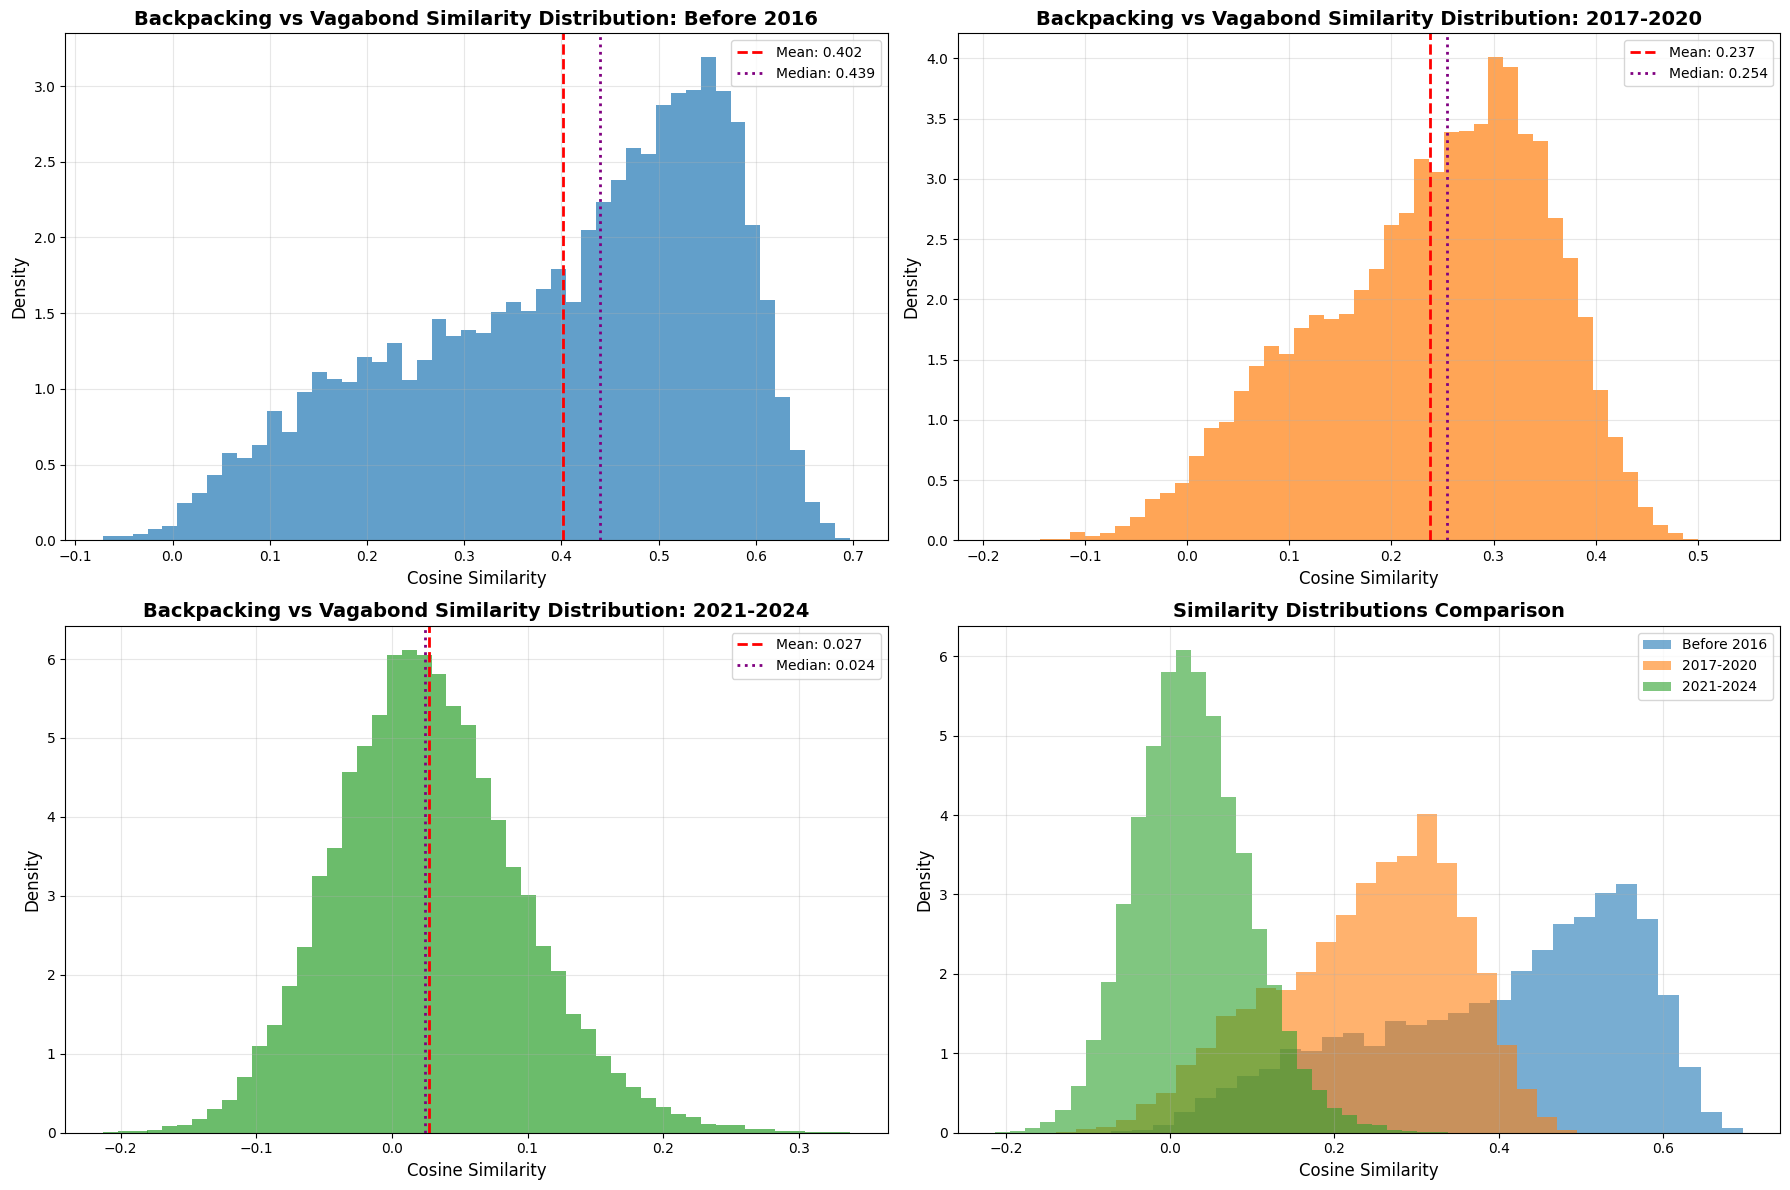


COSINE SIMILARITY DISTRIBUTION ANALYSIS

Before 2016 Statistics:
  Mean similarity: 0.4017
  Median similarity: 0.4394
  Std similarity: 0.1608
  Min similarity: -0.0719
  Max similarity: 0.6969
  Words with similarity < 0.0: 36/10115 (0.4%)
  Words with similarity < -0.1: 0/10115 (0.0%)

2017-2020 Statistics:
  Mean similarity: 0.2374
  Median similarity: 0.2544
  Std similarity: 0.1123
  Min similarity: -0.1882
  Max similarity: 0.5440
  Words with similarity < 0.0: 366/15180 (2.4%)
  Words with similarity < -0.1: 21/15180 (0.1%)

2021-2024 Statistics:
  Mean similarity: 0.0273
  Median similarity: 0.0241
  Std similarity: 0.0685
  Min similarity: -0.2132
  Max similarity: 0.3377
  Words with similarity < 0.0: 7627/21492 (35.5%)
  Words with similarity < -0.1: 495/21492 (2.3%)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
df_before_2016 = pd.read_csv("output/output_distribution/party_comparison_before_2016.csv")
df_2017_2020 = pd.read_csv("output/output_distribution/party_comparison_2017_2020.csv") 
df_2021_2024 = pd.read_csv("output/output_distribution/party_comparison_2021_2024.csv")



def analyze_similarity_distributions():
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        std_sim = df['similarity'].std()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')
        
        plt.title(f'Backpacking vs Vagabond Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("COSINE SIMILARITY DISTRIBUTION ANALYSIS")
    
    for df, period in zip(dataframes, period_names):
        print(f"\n{period} Statistics:")
        print(f"  Mean similarity: {df['similarity'].mean():.4f}")
        print(f"  Median similarity: {df['similarity'].median():.4f}")
        print(f"  Std similarity: {df['similarity'].std():.4f}")
        print(f"  Min similarity: {df['similarity'].min():.4f}")
        print(f"  Max similarity: {df['similarity'].max():.4f}")
        print(f"  Words with similarity < 0.0: {(df['similarity'] < 0.0).sum()}/{len(df)} ({(df['similarity'] < 0.0).mean()*100:.1f}%)")
        print(f"  Words with similarity < -0.1: {(df['similarity'] < -0.1).sum()}/{len(df)} ({(df['similarity'] < -0.1).mean()*100:.1f}%)")


# Run the analysis
similarity_stats = analyze_similarity_distributions()

In [7]:
def compare_multiple_embeddings(base_model, models_dict, output_file=None):
    """
    Compare multiple word2vec models by aligning their vector spaces to a base model.
    
    Args:
        base_model: The reference Word2Vec model
        models_dict: Dictionary of {model_name: model_object} for models to compare
        output_file: Optional path to save CSV results
    
    Returns:
        DataFrame with word similarities across all models
    """
    # Extract base model vocabulary
    base_vocab = set(base_model.wv.index_to_key)
    
    # Find common vocabulary across all models
    common_vocab = base_vocab.copy()
    for name, model in models_dict.items():
        model_vocab = set(model.wv.index_to_key)
        common_vocab = common_vocab.intersection(model_vocab)
    
    common_vocab = list(common_vocab)
    print(f"Common vocabulary size: {len(common_vocab)} words")
    
    # Extract base embeddings for common words
    base_vectors = np.array([base_model.wv[word] for word in common_vocab])
    
    # Calculate similarities for each model
    similarities = {name: [] for name in models_dict.keys()}
    
    for name, model in models_dict.items():
        # Extract model vectors for common words
        model_vectors = np.array([model.wv[word] for word in common_vocab])
        
        # Compute rotational alignment with base model
        m = base_vectors.T @ model_vectors
        u, _, vt = np.linalg.svd(m)
        rotation = u @ vt
        
        # Apply rotation to align model's space with base model's space
        model_vectors_aligned = model_vectors @ rotation
        
        # Calculate word-by-word similarities
        for i, word in enumerate(common_vocab):
            sim = cosine_similarity(base_vectors[i].reshape(1, -1), 
                                   model_vectors_aligned[i].reshape(1, -1))[0][0]
            similarities[name].append(sim)
    
    # Create DataFrame
    df = pd.DataFrame({'word': common_vocab})
    
    # Add similarity columns for each model
    for name, sims in similarities.items():
        df[f'{name}_similarity'] = sims
    
    # Sort by the first similarity column (arbitrary choice)
    first_sim_col = f'{list(similarities.keys())[0]}_similarity'
    df = df.sort_values(first_sim_col)
    
    # Save to file if requested
    if output_file:
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

In [8]:
# Load all models
model_democrats_before_2016 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_democrats_before_2016.model")
model_republican_before_2016 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_republican_before_2016.model")
model_backpacking = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_backpacking_before_2016.model")
model_vagabond = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_vagabond_before_2016.model")

# Choose a base model
base_model = model_democrats_before_2016

# Create a dictionary of models to compare
models_to_compare = {
    "republican": model_republican_before_2016,
    "backpacking": model_backpacking,
    "vagabond": model_vagabond
}

# Compare all models against the base model
df_comparison = compare_multiple_embeddings(
    base_model=base_model,
    models_dict=models_to_compare,
    output_file="output/output_distribution/multi_model_comparison.csv"
)

# Display results
print(df_comparison.head())

# Calculate mean similarities
for model_name in models_to_compare.keys():
    mean_sim = df_comparison[f"{model_name}_similarity"].mean()
    print(f"Mean similarity with {model_name}: {mean_sim:.4f}")

Common vocabulary size: 7287 words
Results saved to output/output_distribution/multi_model_comparison.csv
        word  republican_similarity  backpacking_similarity  \
2119  become              -0.167704                0.080100   
1968    left              -0.143538                0.022892   
1524     far              -0.142522                0.004847   
4344     put              -0.139896                0.011409   
2507   avoid              -0.137303                0.015704   

      vagabond_similarity  
2119             0.020597  
1968             0.179979  
1524             0.205093  
4344             0.027146  
2507             0.058869  
Mean similarity with republican: 0.2161
Mean similarity with backpacking: 0.2642
Mean similarity with vagabond: 0.4534


In [14]:
def compare_multiple_embeddings_pairwise(base_model, models_dict, output_file=None):
    """
    Compare multiple word2vec models by aligning each one separately to the base model.
    Each model is compared independently to maximize vocabulary overlap for each pair.
    
    Args:
        base_model: The reference Word2Vec model
        models_dict: Dictionary of {model_name: model_object} for models to compare
        output_file: Optional path to save CSV results
    
    Returns:
        Dictionary of DataFrames with pairwise comparisons
    """
    # Extract base model vocabulary
    base_vocab = set(base_model.wv.index_to_key)
    results = {}
    
    # Process each model separately
    for name, model in models_dict.items():
        print(f"\n--- Comparing {name} to base model ---")
        # Find common vocabulary with this specific model
        model_vocab = set(model.wv.index_to_key)
        common_vocab = base_vocab.intersection(model_vocab)
        common_vocab = list(common_vocab)
        
        print(f"Common vocabulary size with {name}: {len(common_vocab)} words")
        
        # Extract embeddings for common words
        base_vectors = np.array([base_model.wv[word] for word in common_vocab])
        model_vectors = np.array([model.wv[word] for word in common_vocab])
        
        # Compute rotational alignment with base model
        m = base_vectors.T @ model_vectors
        u, _, vt = np.linalg.svd(m)
        rotation = u @ vt
        
        # Apply rotation to align model's space with base model's space
        model_vectors_aligned = model_vectors @ rotation
        
        # Calculate word-by-word similarities
        similarities = []
        for i, word in enumerate(common_vocab):
            sim = cosine_similarity(base_vectors[i].reshape(1, -1), 
                                   model_vectors_aligned[i].reshape(1, -1))[0][0]
            similarities.append((word, sim))
        
        # Create DataFrame for this comparison
        df = pd.DataFrame(similarities, columns=['word', f'{name}_similarity'])
        
        # Sort by similarity
        df = df.sort_values(f'{name}_similarity')
        
        # Store in results
        results[name] = df
        
        # Calculate and display mean similarity
        mean_sim = df[f'{name}_similarity'].mean()
        print(f"Mean similarity with {name}: {mean_sim:.4f}")
    
    # Merge all results into a single dataframe for saving
    if output_file:
        # Start with first dataframe
        first_name = list(results.keys())[0]
        merged_df = results[first_name].copy()
        
        # Merge with other dataframes
        for name in list(results.keys())[1:]:
            merged_df = pd.merge(merged_df, results[name], on='word', how='outer')
        
        # Save to file
        merged_df.to_csv(output_file, index=False)
        print(f"\nResults saved to {output_file}")
    
    return results

In [5]:
# Load all models
model_democrats_before_2016 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_democrats_before_2016.model")
model_republican_before_2016 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_republican_before_2016.model")
model_backpacking_before_2016 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_backpacking_before_2016.model")
model_vagabond_before_2016 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_vagabond_before_2016.model")
model_democrats_2017_2020 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_democrats_2017_2020.model")
model_republican_2017_2020 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_republican_2017_2020.model")
model_backpacking_2017_2020 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_backpacking_2017_2020.model")
model_vagabond_2017_2020 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_vagabond_2017_2020.model")
model_democrats_2021_2024 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_democrats_2021_2024.model")
model_republican_2021_2024 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_republican_2021_2024.model")
model_backpacking_2021_2024 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_backpacking_2021_2024.model")
model_vagabond_2021_2024 = gensim.models.Word2Vec.load("models/models_distribution/reddit_word2vec_vagabond_2021_2024.model")


# Create a dictionary of models to compare
models_to_compare_before_2016 = {
    "republican": model_republican_before_2016,
    "backpacking": model_backpacking_before_2016,
    "vagabond": model_vagabond_before_2016
}

model_to_compare_2017_2020 = {
    "republican": model_republican_2017_2020,
    "backpacking": model_backpacking_2017_2020,
    "vagabond": model_vagabond_2017_2020
}

model_to_compare_2021_2024 = {
    "republican": model_republican_2021_2024,
    "backpacking": model_backpacking_2021_2024,
    "vagabond": model_vagabond_2021_2024
}

# Compare all models against the base model
compare_multiple_embeddings_pairwise(
    base_model=model_democrats_before_2016,
    models_dict=models_to_compare_before_2016,
    output_file="output/output_distribution/pairwise_model_comparison_before_2016.csv"
)

compare_multiple_embeddings_pairwise(
    base_model=model_democrats_2017_2020,
    models_dict=model_to_compare_2017_2020,
    output_file="output/output_distribution/pairwise_model_comparison_2017_2020.csv"
)

compare_multiple_embeddings_pairwise(
    base_model=model_democrats_2021_2024,
    models_dict=model_to_compare_2021_2024,
    output_file="output/output_distribution/pairwise_model_comparison_2021_2024.csv"
)


NameError: name 'compare_multiple_embeddings_pairwise' is not defined

In [16]:
def plot_cross_temporal_similarity_distributions(model_name, output_file=None):
    """
    Plot similarity distributions across time periods for a specific model comparison.
    
    Args:
        model_name: Name of the model to compare (e.g., "republican", "backpacking", "vagabond")
        output_file: Optional path to save the plot
    """
    # Read CSV files with pairwise comparisons
    before_2016_df = pd.read_csv("output/output_distribution/pairwise_model_comparison_before_2016.csv")
    period_2017_2020_df = pd.read_csv("output/output_distribution/pairwise_model_comparison_2017_2020.csv")
    period_2021_2024_df = pd.read_csv("output/output_distribution/pairwise_model_comparison_2021_2024.csv")
    
    # Extract similarity columns for the specified model
    sim_col = f'{model_name}_similarity'
    
    # Create lists of dataframes and period names
    dataframes = [
        before_2016_df.dropna(subset=[sim_col]), 
        period_2017_2020_df.dropna(subset=[sim_col]),
        period_2021_2024_df.dropna(subset=[sim_col])
    ]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create figure with 2x2 subplots
    plt.figure(figsize=(16, 14))
    
    # Colors for different time periods
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Plot individual distributions in the first 3 subplots
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df[sim_col], bins=50, alpha=0.7, density=True, color=color)
        
        # Add statistics
        mean_sim = df[sim_col].mean()
        median_sim = df[sim_col].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')
        
        plt.title(f'Democrats vs {model_name.capitalize()}: {period}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Plot combined distributions in the fourth subplot
    plt.subplot(2, 2, 4)
    
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df[sim_col], bins=40, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title(f'Democrats vs {model_name.capitalize()}: Temporal Comparison', 
             fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save if requested
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    plt.show()
    
    # Print statistics for each period
    print(f"\n=== Democrats vs {model_name.capitalize()} Similarity Statistics ===")
    
    for df, period in zip(dataframes, period_names):
        print(f"\n{period}:")
        print(f"  Mean similarity: {df[sim_col].mean():.4f}")
        print(f"  Median similarity: {df[sim_col].median():.4f}")
        print(f"  Std similarity: {df[sim_col].std():.4f}")
        print(f"  Min similarity: {df[sim_col].min():.4f}")
        print(f"  Max similarity: {df[sim_col].max():.4f}")
        print(f"  Words with similarity < 0.0: {(df[sim_col] < 0.0).sum()}/{len(df)} ({(df[sim_col] < 0.0).mean()*100:.1f}%)")
        print(f"  Words with similarity < -0.1: {(df[sim_col] < -0.1).sum()}/{len(df)} ({(df[sim_col] < -0.1).mean()*100:.1f}%)")

Plot saved to output/output_distribution/republican_temporal_comparison.png


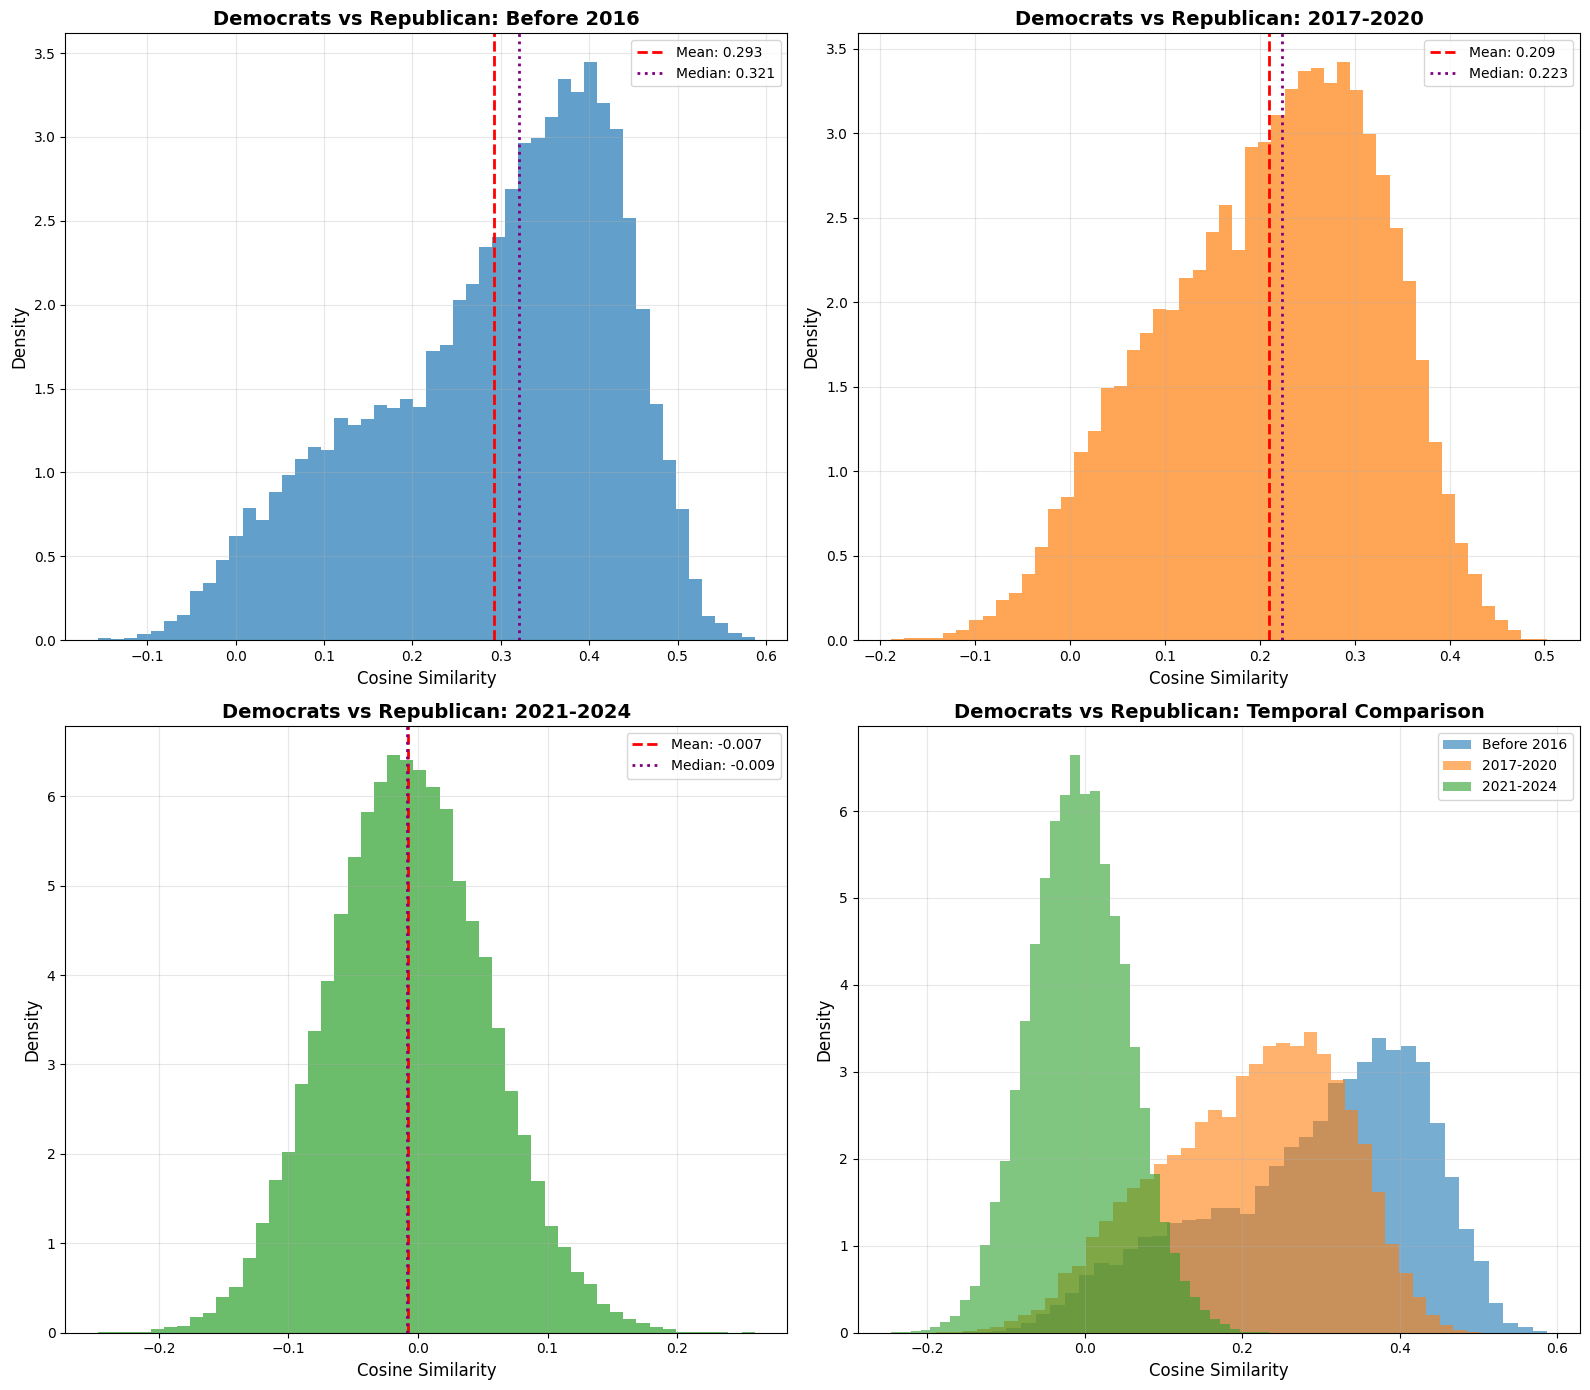


=== Democrats vs Republican Similarity Statistics ===

Before 2016:
  Mean similarity: 0.2926
  Median similarity: 0.3209
  Std similarity: 0.1369
  Min similarity: -0.1556
  Max similarity: 0.5873
  Words with similarity < 0.0: 505/19221 (2.6%)
  Words with similarity < -0.1: 15/19221 (0.1%)

2017-2020:
  Mean similarity: 0.2091
  Median similarity: 0.2229
  Std similarity: 0.1150
  Min similarity: -0.1893
  Max similarity: 0.5029
  Words with similarity < 0.0: 1176/26785 (4.4%)
  Words with similarity < -0.1: 71/26785 (0.3%)

2021-2024:
  Mean similarity: -0.0074
  Median similarity: -0.0085
  Std similarity: 0.0610
  Min similarity: -0.2468
  Max similarity: 0.2598
  Words with similarity < 0.0: 18661/33730 (55.3%)
  Words with similarity < -0.1: 2099/33730 (6.2%)
Plot saved to output/output_distribution/backpacking_temporal_comparison.png


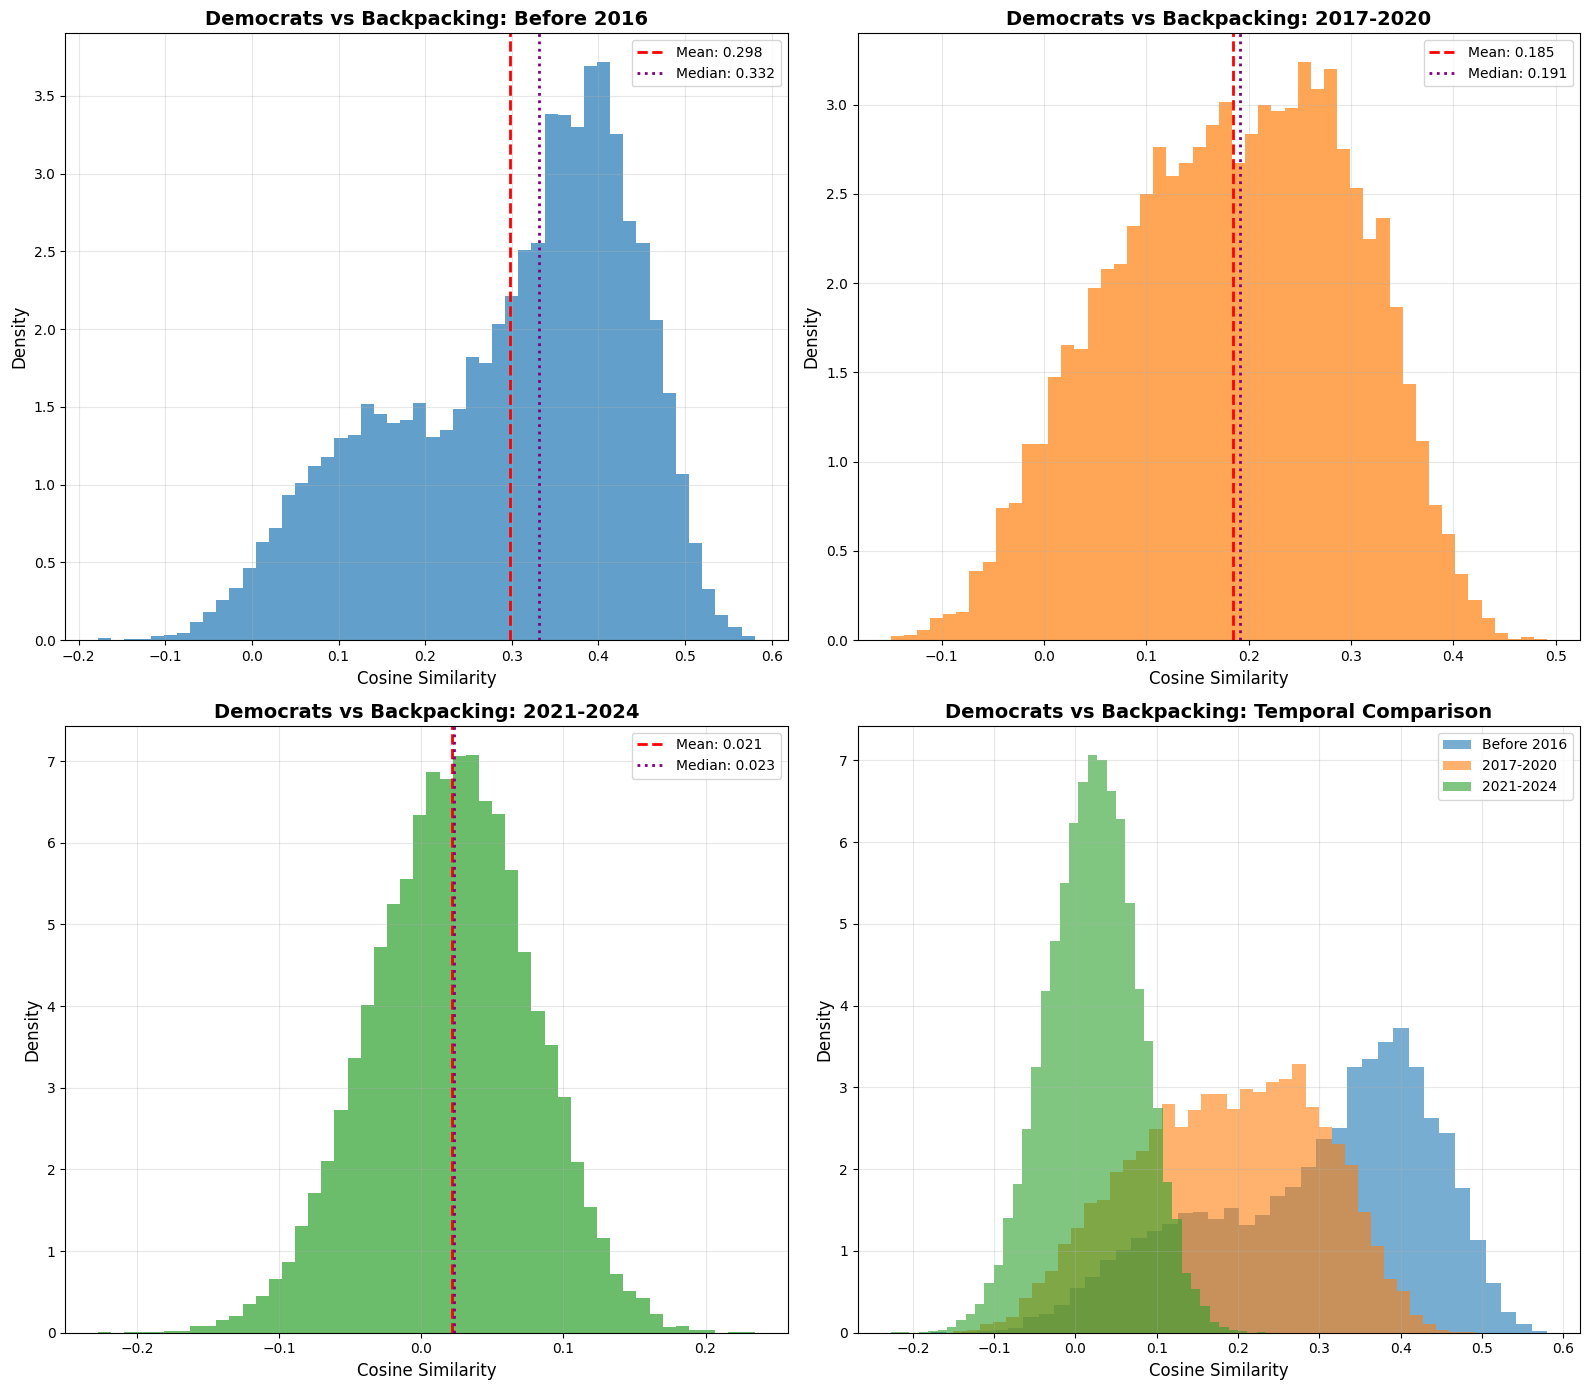


=== Democrats vs Backpacking Similarity Statistics ===

Before 2016:
  Mean similarity: 0.2981
  Median similarity: 0.3317
  Std similarity: 0.1376
  Min similarity: -0.1776
  Max similarity: 0.5803
  Words with similarity < 0.0: 215/10438 (2.1%)
  Words with similarity < -0.1: 8/10438 (0.1%)

2017-2020:
  Mean similarity: 0.1845
  Median similarity: 0.1910
  Std similarity: 0.1139
  Min similarity: -0.1500
  Max similarity: 0.4916
  Words with similarity < 0.0: 776/12882 (6.0%)
  Words with similarity < -0.1: 37/12882 (0.3%)

2021-2024:
  Mean similarity: 0.0214
  Median similarity: 0.0227
  Std similarity: 0.0562
  Min similarity: -0.2274
  Max similarity: 0.2346
  Words with similarity < 0.0: 7019/20248 (34.7%)
  Words with similarity < -0.1: 352/20248 (1.7%)
Plot saved to output/output_distribution/vagabond_temporal_comparison.png


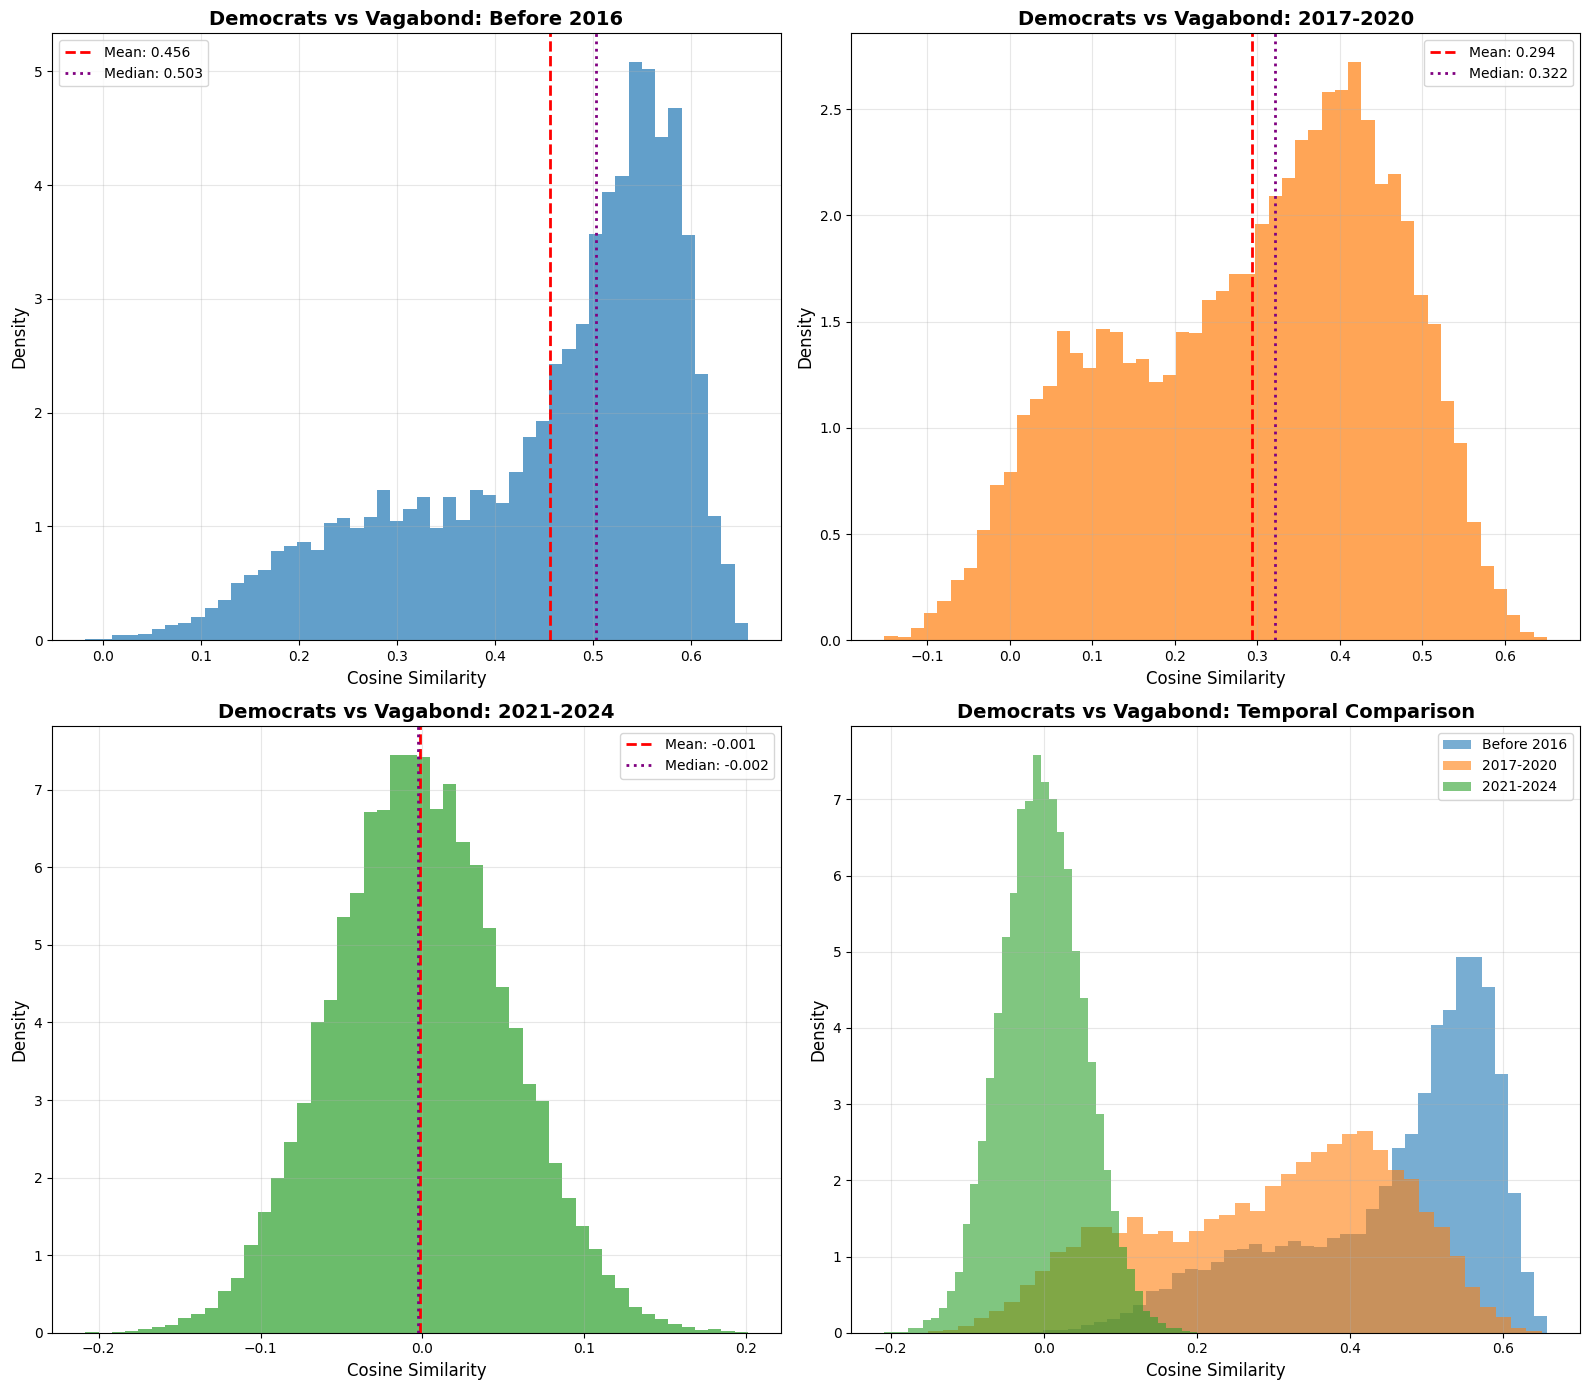


=== Democrats vs Vagabond Similarity Statistics ===

Before 2016:
  Mean similarity: 0.4558
  Median similarity: 0.5028
  Std similarity: 0.1353
  Min similarity: -0.0183
  Max similarity: 0.6578
  Words with similarity < 0.0: 1/8038 (0.0%)
  Words with similarity < -0.1: 0/8038 (0.0%)

2017-2020:
  Mean similarity: 0.2942
  Median similarity: 0.3221
  Std similarity: 0.1637
  Min similarity: -0.1517
  Max similarity: 0.6510
  Words with similarity < 0.0: 656/15335 (4.3%)
  Words with similarity < -0.1: 29/15335 (0.2%)

2021-2024:
  Mean similarity: -0.0014
  Median similarity: -0.0025
  Std similarity: 0.0537
  Min similarity: -0.2083
  Max similarity: 0.2010
  Words with similarity < 0.0: 10742/20755 (51.8%)
  Words with similarity < -0.1: 631/20755 (3.0%)


In [17]:
# Plot distributions for Republican models across time periods
plot_cross_temporal_similarity_distributions(
    model_name="republican", 
    output_file="output/output_distribution/republican_temporal_comparison.png"
)

# Plot distributions for Backpacking models across time periods
plot_cross_temporal_similarity_distributions(
    model_name="backpacking", 
    output_file="output/output_distribution/backpacking_temporal_comparison.png"
)

# Plot distributions for Vagabond models across time periods
plot_cross_temporal_similarity_distributions(
    model_name="vagabond", 
    output_file="output/output_distribution/vagabond_temporal_comparison.png"
)